<a href="https://colab.research.google.com/github/djramakrishna/EE577/blob/main/apply_wavelet_transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
from google.colab.patches import cv2_imshow
import warnings
warnings.filterwarnings("ignore")
from skimage import data, segmentation, color
from skimage.future import graph
from torchvision import transforms
! pip install kymatio
from kymatio.torch import Scattering2D
import pickle

In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
def load_data_suffix(path,images_to_load=50,resize=True,resize_dim=(512,512),valid_suffix='Mask'):
  '''
  The function loads the data based on a single valid suffix in the file name.
  
  Parameters
  ----------
  path : The path where the images are located.
  images_to_load : Maximum number of images to load.
  resize : Whether to resize the image.
  resize_dim : Specify dimensions for resizing, used only when resize=True.

  Return
  ------
  Loaded image and filename as a tuple for each entry.
  '''
  valid_images = [valid_suffix]
  img_dict = {}
  for f in os.listdir(path):
    ext = os.path.splitext(f)[0]
    if ext.split('_')[1] not in valid_images:
        continue
    img = cv2.imread(os.path.join(path,f))
    if resize:
      img = cv2.resize(img, resize_dim)
    img_dict.update({f[:4]:img})
  return img_dict


In [6]:
# 1. Define the path directory for the images
melanoma_img_path = '/content/gdrive/MyDrive/CS_EE_577/Dataset/SegmentedImages_NormalizedCut/Melanoma/'
non_melanoma_img_path = '/content/gdrive/MyDrive/CS_EE_577/Dataset/SegmentedImages_NormalizedCut/Non_Melanoma/'

In [7]:
# 2. Read RGB Segmented Images
m_segment_dict = load_data_suffix(melanoma_img_path,valid_suffix='SegmentedImage')
nm_segment_dict = load_data_suffix(non_melanoma_img_path,valid_suffix='SegmentedImage')

In [8]:
# 3. Read Depth Segmented Images
m_depth_segment_dict = load_data_suffix(melanoma_img_path,valid_suffix='SegmentedDepthImage')
nm_depth_segment_dict = load_data_suffix(non_melanoma_img_path,valid_suffix='SegmentedDepthImage')

In [9]:
# key = '0121'
# img = m_depth_segment_dict[key]
# cv2_imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
#cv2_imshow(m_depth_segment_dict[key])

In [12]:
from PIL import Image
def generate_tensors(rgb_img, depth_img, size, max_order):
  '''
  The function generates tensors for each image category like RGB, RGBZ, Z

  Parameters
  ----------
  rgb_img : The RGB image of a sample.
  depth_img : The depth image of a sample.
  size : The shape to resize the image into.
  max_order : The maximum order of the coefficients for the scattering transform

  Returns
  -------
  A dictionary of RGB, Depth, RGBZ Tensors
  '''
  S = Scattering2D(J=2, L=8,shape=size,max_order=max_order)
  rgb_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize(size=size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])])
  
  depth_transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize(size=size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[6.26],
                                    std=[3.03])])
  depth_img = cv2.cvtColor(depth_img, cv2.COLOR_RGB2GRAY)
  rgb_res = S.scattering(rgb_transform(rgb_img))
  depth_transform(depth_img)
  depth_res = S.scattering(depth_transform(depth_img))
  rgb_depth_res = torch.cat((rgb_res, depth_res), 0)
  return {'RGB Tensors':rgb_res, 'Depth Tensors':depth_res, 'RGBZ Tensors':rgb_depth_res}

In [14]:
lesion_type = ['Melanoma','Non_Melanoma']
coeff_order_lst = [1,2]
size_lst = [(32,32),(64,64),(128,128)]
lesion_dict = {}
lesion_dict['Melanoma'] = [m_segment_dict,m_depth_segment_dict]
lesion_dict['Non_Melanoma'] = [nm_segment_dict,nm_depth_segment_dict]

for lesion in lesion_type:
  segment_dict, depth_segment_dict = lesion_dict[lesion]
  for coeff in coeff_order_lst:
    for size in size_lst:
      for name in depth_segment_dict.keys():
        output = generate_tensors(segment_dict[name], depth_segment_dict[name], size=(size), max_order=coeff)
        tensor_type='RGB'
        path_to_store = f'/content/gdrive/MyDrive/CS_EE_577/Dataset/Tensors/Coeff_Order{coeff}/{tensor_type}_{size[0]}_{size[0]}/{lesion}'
        path_to_store = path_to_store+f'/{name}_RGBTensor.pickle'
        os.makedirs(os.path.dirname(path_to_store), exist_ok=True)
        with open(path_to_store, 'wb') as handle:
          pickle.dump(output['RGB Tensors'], handle)
        
        tensor_type='Z'
        path_to_store = f'/content/gdrive/MyDrive/CS_EE_577/Dataset/Tensors/Coeff_Order{coeff}/{tensor_type}_{size[0]}_{size[0]}/{lesion}'
        path_to_store = path_to_store+f'/{name}_ZTensor.pickle'
        os.makedirs(os.path.dirname(path_to_store), exist_ok=True)
        with open(path_to_store, 'wb') as handle:
          pickle.dump(output['Depth Tensors'], handle) 
        
        tensor_type='RGBZ'
        path_to_store = f'/content/gdrive/MyDrive/CS_EE_577/Dataset/Tensors/Coeff_Order{coeff}/{tensor_type}_{size[0]}_{size[0]}/{lesion}'
        path_to_store = path_to_store+f'/{name}_RGBZTensor.pickle'
        os.makedirs(os.path.dirname(path_to_store), exist_ok=True)
        with open(path_to_store, 'wb') as handle:
          pickle.dump(output['RGBZ Tensors'], handle) 
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


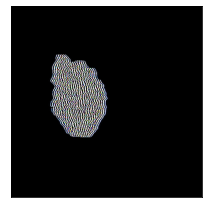

In [38]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data

original = m_segment_dict[key]
coeffs2,_ = pywt.cwt(original,scales=np.arange(1,8),wavelet='morl',method='fft',axis=1)
fig = plt.figure(figsize=(12, 3))
for i in range(1):
    ax = fig.add_subplot(1, 2, i + 1)
    plt.imshow(coeffs2[i+3])
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()